In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement 
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

Text(0, 0.5, 'Precipitation Values')

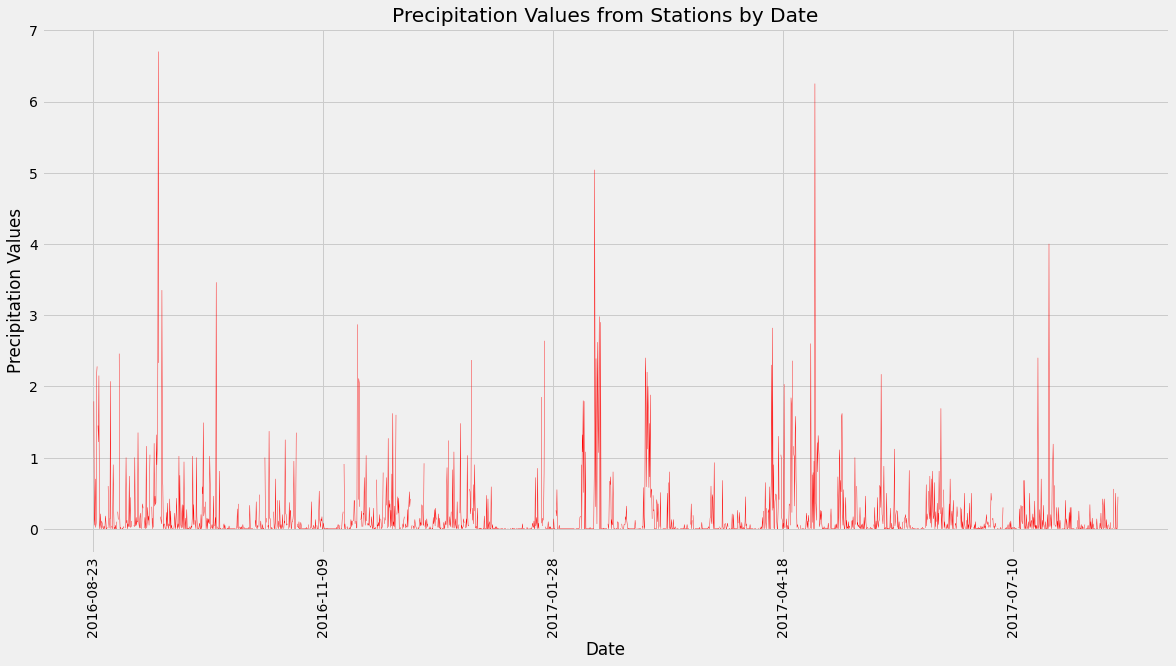

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
prev_year = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Calculate the date 1 year ago from the last data point in the database
year_last = dt.date(2017,8,23)
year_prev = year_last - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
data_precip = (session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>= year_prev))
# Save the query results as a Pandas DataFrame and set the index to the date column
data_precip_df = pd.read_sql_query(data_precip.statement, session.get_bind())
# Sort the dataframe by date
data_precip_df = data_precip_df.sort_values(by="date", ascending=True)
# Use Pandas Plotting with Matplotlib to plot the data
data_precip_df.plot("date", "prcp", figsize=(18,9), legend=False, color="red", linewidth=0.4)
plt.title("Precipitation Values from Stations by Date")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel('Precipitation Values')

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipsum_df = data_precip_df.describe()
precipsum_df = precipsum_df.round(3)
precipsum_df

,prcp
count,2021.000
mean,0.177
std,0.461
min,0.000
25%,0.000
50%,0.020
75%,0.130
max,6.700


In [13]:
# Design a query to show how many stations are available in this dataset?
stat_count = session.query(Station).count()
print(f"The number of stations in the dataset is {stat_count}")

The number of stations in the dataset is 9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stat_dat = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
stat_dat

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
act_stat = stat_dat[0][0]
query_stat = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == act_stat).all()
print(f" The Minimum, Maximum and Average Temperatures at station {act_stat} were {query_stat} respectively")

 The Minimum, Maximum and Average Temperatures at station USC00519281 were [(54.0, 85.0, 71.66378066378067)] respectively


Text(0, 0.5, 'Readings')

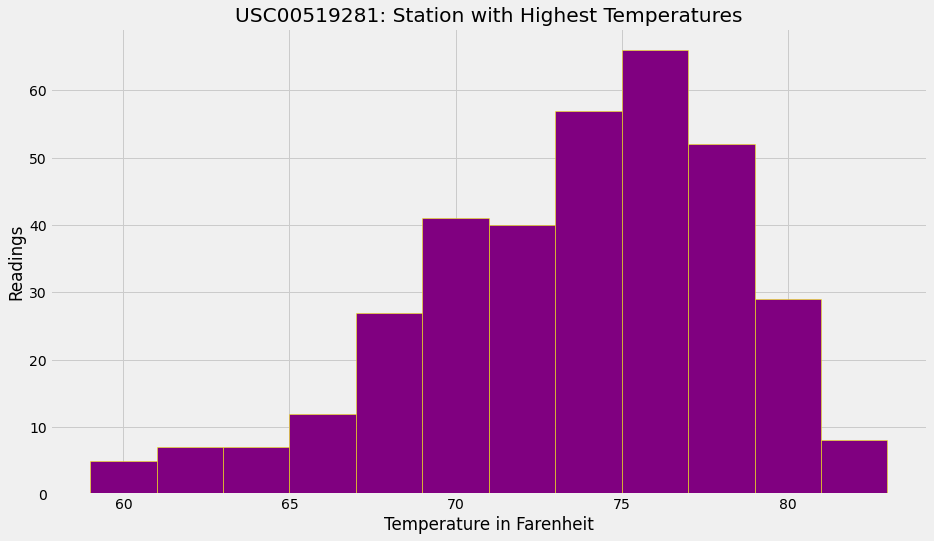

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_stat = session.query(Measurement.tobs).\
    filter(Measurement.date > year_prev).\
    filter(Measurement.station == act_stat).all()
#Pd.Dataframe 
high_stat_df = pd.DataFrame(high_stat)

high_stat_df.plot.hist('tobs', bins=12, figsize=(14,8), title=(f'{act_stat}: Station with Highest Temperatures'),legend=False, color="purple", edgecolor="yellow")
plt.xlabel('Temperature in Farenheit')
plt.ylabel('Readings')

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_cur = dt.date(2012,2,28)
end_cur = dt.date(2012,3,5)
start_prev = start_cur - dt.timedelta(days=365)
end_prev = end_cur - dt.timedelta(days=365)
tmin, tavg, tmax = calc_temps(start_prev.strftime("%Y-%m-%d"), end_prev.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

61.0 70.08928571428571 75.0


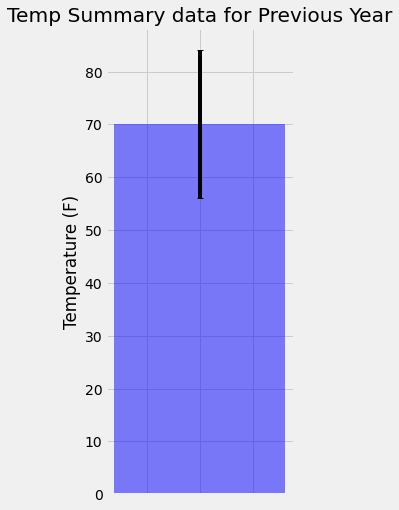

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize = (3,8))
xpos = 1
yerr = tmax-tmin
ax.bar(xpos, tavg, yerr=yerr, align='center', alpha=0.5, color="blue", capsize=3, ecolor="black")
ax.set_ylabel("Temperature (F)")
ax.set_title("Temp Summary data for Previous Year")
plt.tick_params(
    axis ='x',
    bottom=False,
    top=False,
    labelbottom=False,
)
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

select = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

result = session.query(*select).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_prev).\
    filter(Measurement.date <= end_prev).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
result_df = pd.DataFrame(result, columns = ['Station', 'Name', 'Latitude', 'Longitude', 'Elevation','Precipitation'])
result_df

,Station,Name,Latitude,Longitude,Elevation,Precipitation
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,3.74
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2.60
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.60
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.46
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,2.33
5,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.69
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.41
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.63
8,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = dt.datetime.strftime(start_cur, "%m-%d")
end = dt.datetime.strftime(end_cur, "%m-%d")
#convert strings to datetime obj
start = dt.datetime.strptime(start, "%m-%d")
end = dt.datetime.strptime(end, "%m-%d")
# Use the start and end date to create a range of dates
date_range = (start +dt.timedelta(days=x) for x in range(0,((end-start).days)+1))
# Stip off the year and save a list of %m-%d strings
date_list = []
for date_object in date_range:
    str_date = date_object.strftime("%m-%d")
    date_list.append(str_date)
# Loop through the list of %m-%d strings and calculate the normals for each date
daily_norms = []
for date in date_list:
    daily_norms.append(daily_normals(date))
print(daily_norms)

[[(65.0, 70.65517241379311, 80.0)], [(64.0, 70.0327868852459, 76.0)], [(61.0, 70.36666666666666, 78.0)], [(60.0, 70.06896551724138, 78.0)], [(57.0, 69.27272727272727, 77.0)], [(60.0, 67.89090909090909, 76.0)]]


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
min_list = []
avg_list = []
max_list = []
for daily_normals in daily_norms:
    for min_temp, avg_temp, max_temp in daily_normals:
        min_list.append(min_temp)
        avg_list.append(avg_temp)
        max_list.append(max_temp)

daily_norms_df = pd.DataFrame({
    "Date": date_list,
    "Min": min_list,
    "Max": max_list,
    "Avg": avg_list
})
daily_norms_df = daily_norms_df.set_index("Date")
daily_norms_df

,Min,Max,Avg
Date,,,
02-28,65.0,80.0,70.655172
03-01,64.0,76.0,70.032787
03-02,61.0,78.0,70.366667
03-03,60.0,78.0,70.068966
03-04,57.0,77.0,69.272727
03-05,60.0,76.0,67.890909


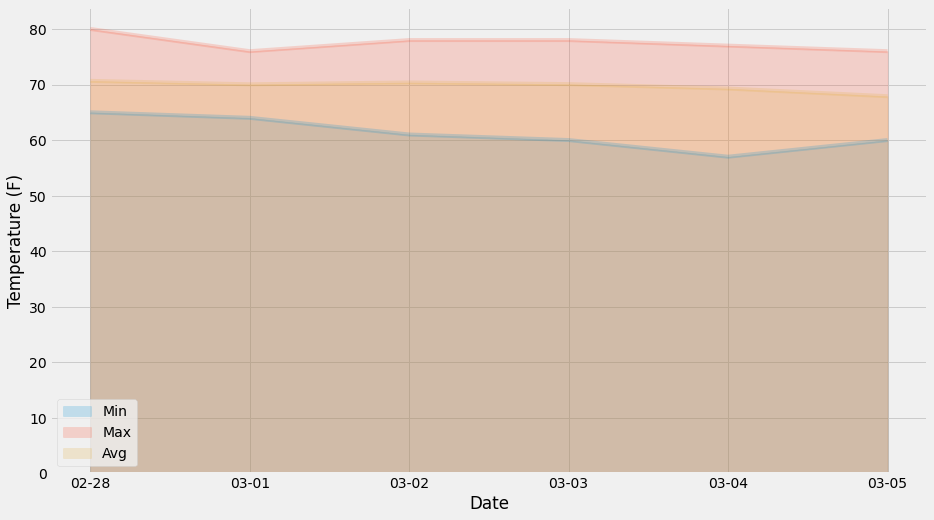

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
daily_norms_df.plot(kind='area', stacked=False, x_compat=True, alpha=.2, figsize=[14,8])
plt.ylabel('Temperature (F)')
plt.show()